# Data Augmentation for Semantic Image Segmentation

## Goal
The goal of this notebook is to **implement, test, and integrate data augmentation techniques** for semantic image segmentation using the **KITTI Segmentation Dataset**.  
By applying augmentation, we aim to:
- Increase dataset diversity without collecting additional samples.  
- Improve the **robustness and generalization** of the segmentation model (U-Net).  
- Compare performance between models trained **with** and **without** augmentation.

---

## Dataset
- **KITTI Semantic Segmentation Dataset**  
- 200 manually annotated images.  
- RGB images: `datasets/kitti/image_2`  
- Ground-truth labels: `datasets/kitti/semantic_rgb`

---

## Procedure / Notebook Steps
1. **Dataset Preparation**
   - Load and shuffle image-label pairs.  
   - Visualize samples.  

2. **Implement Augmentation Functions**
   - Random Flip  
   - Random Gamma Correction  
   - Random Brightness Adjustment  
   - Random Contrast Adjustment  
   - Random Noise Injection  
   - Random Zoom  

3. **Define Augmentation Policy**
   - Combine multiple augmentations into subpolicies with probabilities.  
   - Apply subpolicies randomly during training.  

4. **Integrate with `tf.data` Pipeline**
   - Wrap augmentation functions.  
   - Build training and validation datasets (`70% / 30% split`).  
   - Apply augmentations only to training set.  

5. **Model Training**
   - Load U-Net segmentation model.  
   - Train with augmentation vs. without augmentation.  
   - Compare model performance.  

6. **Model Evaluation & Inference**
   - Evaluate model on validation set.  
   - Visualize segmentation predictions.  
   - Show improvements due to augmentation.  

---

## Expected Outcome
- A trained segmentation model with **better accuracy and robustness** when using augmentation.  
- Visualization of various augmentation effects and their impact on model performance.


In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import glob
import random

os.environ["MPLCONFIGDIR"] = "/tmp/matplotlib"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

from segmentation_utils.metrics import SparseMeanIoU

random.seed(123)
tf.random.set_seed(42)

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 12)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-19q7ewu9 because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2025-09-30 19:28:05.245028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-30 19:28:05.381972: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Dataset

We will work with the [KITTI Segmentation Dataset](http://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015), which contains **200 manually annotated images**. The RGB input images can be found in the folder `datasets/kitti/image_2`, while the corresponding labeled images are stored in `datasets/kitti/semantic_rgb`.

In [2]:
images_path_train = "datasets/kitti/image_2"
labels_path_train = "datasets/kitti/semantic_rgb"

# get file pathes
images_path_train = sorted(glob.glob(os.path.join(images_path_train, "*.png")))
labels_path_train = sorted(glob.glob(os.path.join(labels_path_train, "*.png")))

# shuffle the dataset
fused_list = list(zip(images_path_train, labels_path_train))
random.shuffle(fused_list)
images_path_train, labels_path_train = map(list, zip(*fused_list))

### Import Helper Functions

Previously, we implemented the following functions:

* `parse_sample(image_path, label_path)`
* `convert_rgb_encoding_to_segmentation_map(image, rgb_to_class_id)`
* `segmentation_map_to_rgb_encoding(segmentation_map, rgb_to_class_id)`

For convenience, we will now import the correctly implemented versions of these functions from `image_segmentation_utils.py`. Additionally, we will import the class-color mapping dictionary:

* `rgb_to_class_id`

This allows us to use the previously defined functionality directly in the current pipeline.


In [3]:
from segmentation_utils.image_segmentation_utils import *

## Dataset inspection
We will just have a peak on the first sample of the dataset. This sample is used to implement and test several augmentation methods.

In [4]:
image, label = parse_sample(images_path_train[10], labels_path_train[10])

2025-09-30 19:28:09.402482: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-09-30 19:28:09.402505: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-09-30 19:28:09.402521: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2025-09-30 19:28:09.405211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


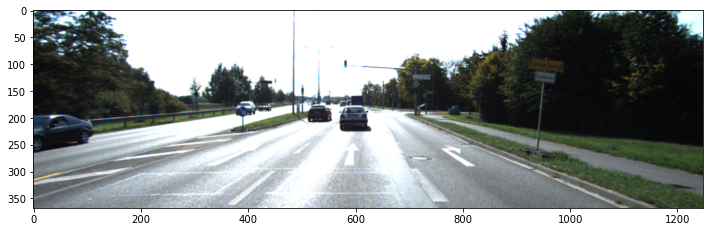

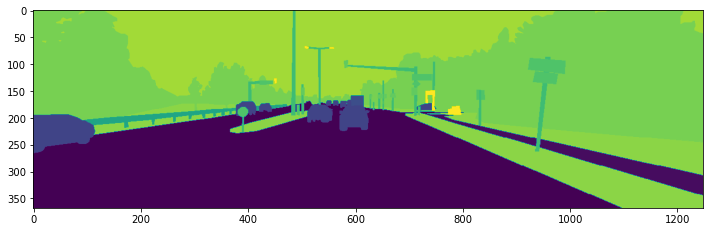

In [5]:
plt.imshow(image)
plt.show()
plt.imshow(label)
plt.show()

## Task: Implement Random Flip

In this task, you will implement a **random horizontal flip** for image-label pairs. Each pair should be flipped with a probability of 0.5. This augmentation helps the model become more robust to different object positions in the scene.

Steps to implement the random flip:

1. **Generate a random condition** to decide whether to flip the image-label pair.
2. **Flip when condition is met**: If the random value indicates a flip, apply a horizontal flip to both the image and the label.
3. **Keep original otherwise**: If the condition is not met, leave the image and label unchanged.

This augmentation ensures that the model sees objects in varying orientations, improving generalization.


In [6]:
def random_flip(image, label):
    """
    Randomly flips the image-label pair along the 1-dimension with probability 0.5.

    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map

    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- Augmented tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    # creates a random float between 0 and 1
    random = tf.random.uniform(shape=[], minval=0, maxval=1, dtype=tf.float16)

    (image, label) = tf.cond(
        pred=random > 0.5,  # pred=None,
        true_fn=lambda: (
            tf.image.flip_left_right(image),
            tf.image.flip_left_right(label),
        ),  # true_fn=lambda: (None, None),
        false_fn=lambda: (image, label),  # false_fn=lambda: (None, None)
    )
    return image, label

### Test: `random_flip`

We will execute `random_flip` several times and we will plot the result with matplotlib

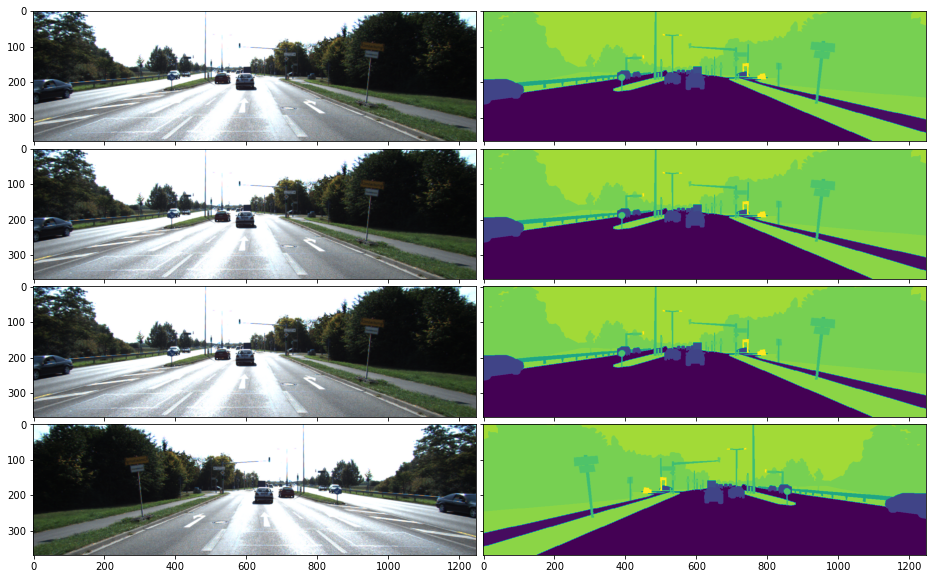

In [7]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(4, 2),
    axes_pad=0.1,
)

for i in range(0, 4 * 2, 2):
    image_augmented, label_augmented = random_flip(image, label)

    grid[i].imshow(image_augmented)
    grid[i + 1].imshow(label_augmented)

You should see that some image-label pairs are flipped horizontally. Execute the above cell block several times and you will see that the input is flipped randomly.

## Implement Random Gamma

Illumination conditions can vary significantly throughout the day or due to shadows from buildings, trees, or bridges. To simulate these variations, a **random gamma correction** is applied to the input image.

Steps to implement random gamma:

1. **Generate a random gamma value**: Create a scalar random value within the range 0.3 to 1.2. This value will determine the strength of the gamma adjustment.
2. **Apply gamma correction**: Adjust the image brightness using the generated gamma value. This produces images with different illumination conditions, improving the model’s robustness to lighting variations.


In [8]:
def random_gamma(image, label):
    """
    Randomly applies gamma augmentation to the image. The label should not be changed.

    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map

    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    random_gamma = tf.random.uniform(
        shape=[], minval=0.3, maxval=1.2, dtype=tf.float32
    )  # random_gamma = None
    image = tf.image.adjust_gamma(image, gamma=random_gamma)  # image = None
    return image, label

### Test: `random_gamma`

In the following we will execute `random_gamma` several times and we will plot the result with matplotlib.

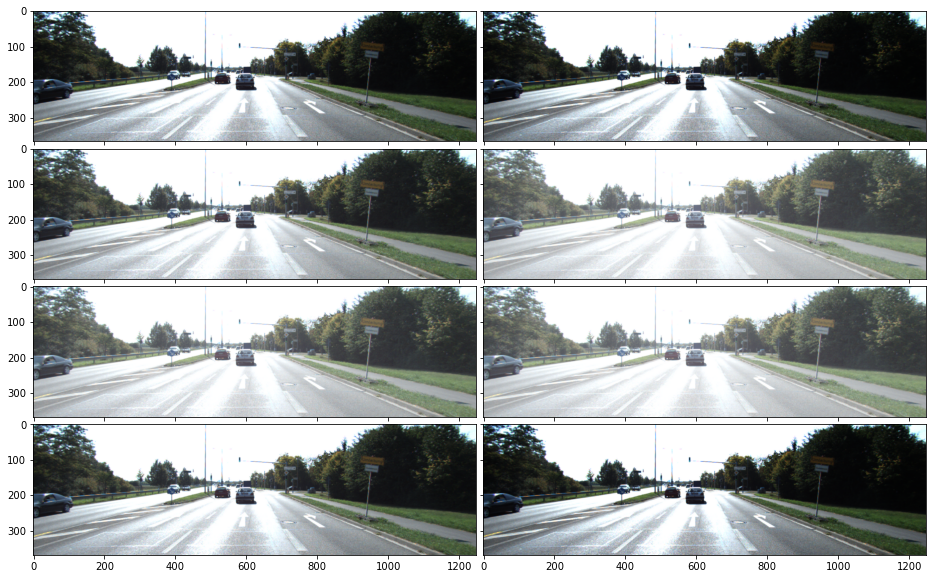

In [9]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(4, 2),
    axes_pad=0.1,
)

for ax in grid:
    image_augmented, label_augmented = random_gamma(image, label)
    ax.imshow(image_augmented)

The input image is augmented with different gamma corrections.

## Random Brightness

Random brightness adjustment is conceptually similar to gamma correction, but it modifies the image in a different way. To introduce diversity in augmentation, a **random brightness transformation** will also be applied.

Steps to implement random brightness:

1. **Apply random brightness**: Use a brightness adjustment method that perturbs the image intensity randomly.
2. **Set variation range**: Limit the maximum change in brightness to a `max_delta` of 0.4.

This augmentation helps the model handle variations in scene lighting more effectively.


In [10]:
def random_brightness(image, label):
    """
    Randomly applies brightness augmentation to the image. The label should not be changed.

    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map

    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    image = tf.image.random_brightness(image, 0.4)  # image = None
    return image, label

### Test: `random_brightness`

In the following we will execute `random_brightness` several times and we will plot the result with matplotlib.

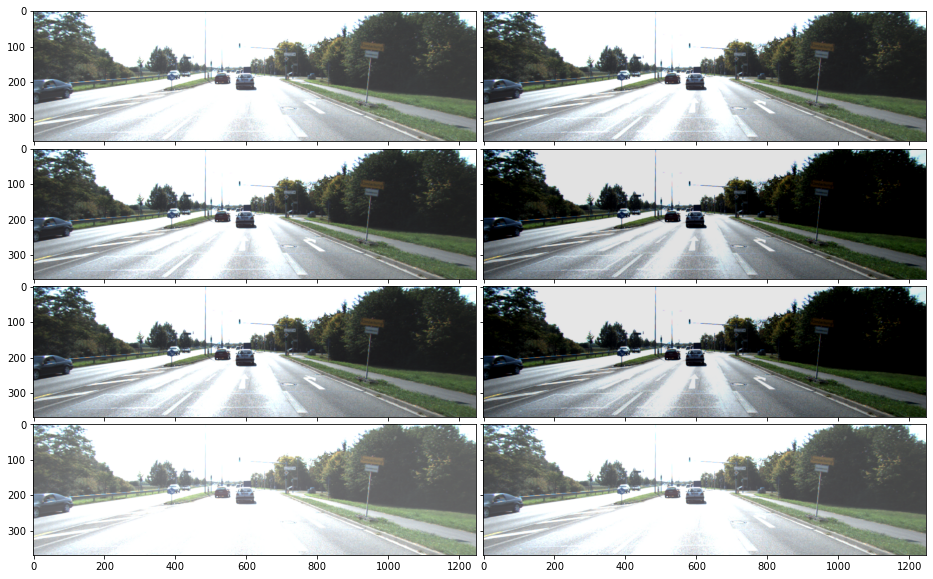

In [11]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(4, 2),
    axes_pad=0.1,
)

for ax in grid:
    image_augmented, label_augmented = random_brightness(image, label)
    ax.imshow(image_augmented)

## Task: Random Contrast

Random contrast adjustment is another common augmentation technique. Similar to `random_brightness`, this method alters the image to simulate variations in lighting and texture, helping the model generalize better.

Steps to implement random contrast:

1. **Apply random contrast**: Use a built-in function to adjust the contrast of the image randomly.
2. **Define the contrast range**: Set the minimum (`lower`) to 0.2 and the maximum (`upper`) to 1.1 to control the degree of variation.

This augmentation introduces additional diversity to the training data by modifying the image contrast dynamically.


In [12]:
def random_contrast(image, label):
    """
    Randomly applies contrast augmentation to the image. The label should not be changed.

    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map

    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    image = tf.image.random_contrast(image, 0.2, 1.1)  # image = None
    return image, label

### Test: `random_contrast`

In the following we will execute `random_contrast` several times and we will plot the result with matplotlib.

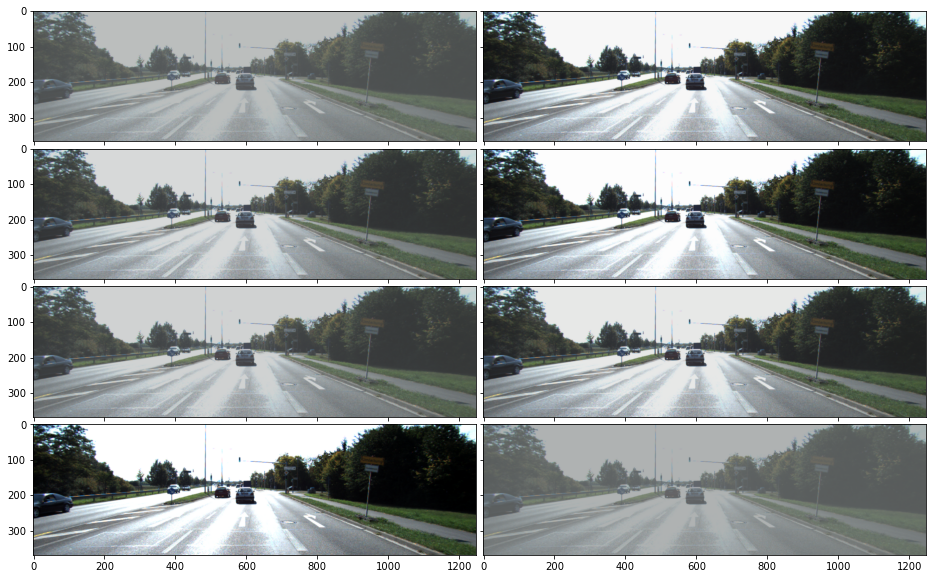

In [13]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(4, 2),
    axes_pad=0.1,
)

for ax in grid:
    image_augmented, label_augmented = random_contrast(image, label)
    ax.imshow(image_augmented)

## Task: Random Noise

Random noise is another data augmentation technique that enhances the robustness of the model. This method works by adding **Gaussian noise** to the input image, simulating small variations or imperfections in real-world data. These slight perturbations help the network generalize better and become less sensitive to minor input fluctuations.

Steps to implement random noise:

1. **Generate a noise tensor**: Create a tensor of the same shape as the input image, with values sampled from a normal (Gaussian) distribution.
2. **Set noise parameters**: Use a mean of 0 and a standard deviation defined by `random_stddev` to control the intensity of the noise. Ensure the tensor has a data type of `tf.float32`.
3. **Prepare the image for addition**: Cast the input image from `tf.uint8` to `tf.float32` to match the noise tensor type.
4. **Add the noise**: Combine the noise tensor with the input image.
5. **Clip values to valid range**: After addition, pixel values may exceed the valid range [0, 255]. Use clipping to ensure all values remain within this range.
6. **Cast back to original type**: Convert the image back to `tf.uint8` so it can be used in the rest of the pipeline.

This augmentation ensures that the model sees slightly altered versions of each image, improving its ability to handle noisy or imperfect input data.


In [14]:
def random_noise(image, label):
    """
    Randomly applies contrast augmentation to the image. The label should not be changed.

    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map

    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """

    # Create a random standart deviation - simulates the intensity of the noise
    random_stddev = tf.random.uniform(shape=[], minval=2, maxval=30, dtype=tf.float32)
    # Create a noise tensor with a shape like the input image. Use zero-mean and a random std
    noise = tf.random.normal(
        tf.shape(image), mean=0.0, stddev=random_stddev, dtype=tf.float32
    )  # noise = tf.random.normal(None, mean=None, stddev=None, dtype=None)

    # Add the noise to the image. Cast the image to tf.float32 before the addition
    image = tf.cast(image, dtype=tf.float32) + noise  # image = None + None

    # Clip the values of the image to [0, 255]
    image = tf.clip_by_value(image, 0.0, 255.0)  # image = None

    # Cast the image back to tf.uint8
    image = tf.cast(image, dtype=tf.uint8)  # image = None

    return image, label

### Test: `random_noise`

In the following we will execute `random_noise` several times and we will plot the result with matplotlib.

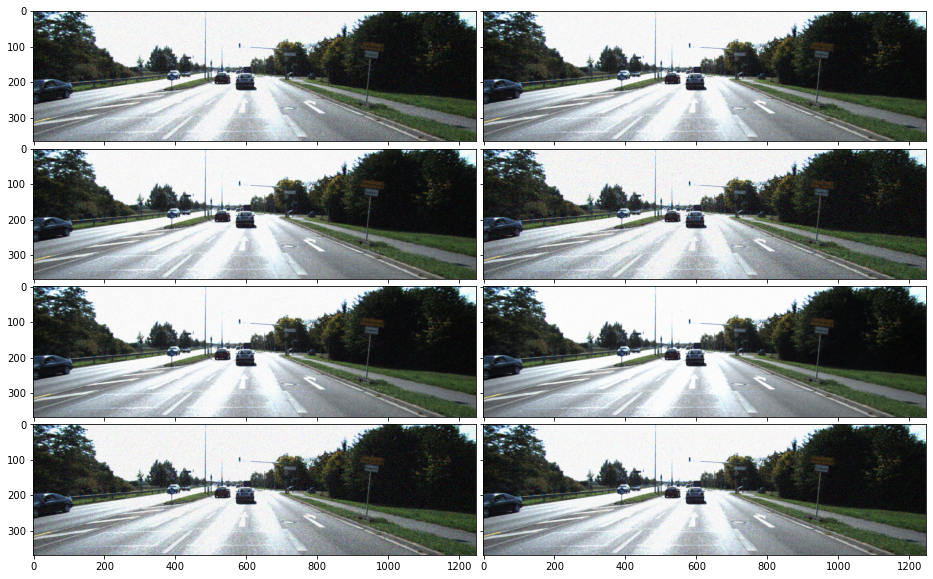

In [15]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(4, 2),
    axes_pad=0.1,
)

for ax in grid:
    image_augmented, label_augmented = random_noise(image, label)
    ax.imshow(image_augmented)

## Task: Random Zoom

Random zoom is a data augmentation technique that modifies the scale of the image and label pair. The image is **randomly enlarged**, and then a crop of the original size is taken. This forces the network to learn features that are **invariant to changes in scale**, improving its ability to recognize objects at different sizes.

In this task, the existing code should be reviewed, and the final two steps of the function need to be completed.

Steps to implement random zoom:

1. **Perform a consistent crop**: Apply the same cropping operation to both the image and its label to preserve alignment.
2. **Set crop parameters**:

   * `offset_height` → vertical coordinate of the top-left corner (`y_top_left`)
   * `offset_width` → horizontal coordinate of the top-left corner (`x_top_left`)
   * `target_height` → original image height (`original_shape[0]`)
   * `target_width` → original image width (`original_shape[1]`)

This ensures that the zoomed image and label are resized back to the original dimensions while introducing scale variation for robust training.


In [16]:
def random_zoom(image, label):
    """
    Randomly applies random zoom augmentation to the image-label pair. Randomly resizes the image
    and then crops it back to original size.

    Arguments:
    image -- tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- tf.Tensor with shape [width, height] representing the corresponding segmentation map

    Returns:
    image -- Augmented tf.Tensor with shape [width, height, 3] representing the camera RGB image
    label -- Augmented tf.Tensor with shape [width, height] representing the corresponding segmentation map
    """
    # Store the original height, width of the input image
    original_shape = tf.shape(image)[:2]

    # Create a random scale between 1 und 2.5
    scale = tf.random.uniform(shape=[], minval=1, maxval=2.5, dtype=tf.float32)

    # Calculate the new dimension after scaling the the original image with scale
    new_dim = tf.cast(
        tf.cast([image.shape[0], image.shape[1]], tf.float32) * scale, tf.int32
    )

    # Resize the image to the new dimension
    image = tf.image.resize(image, new_dim, method=tf.image.ResizeMethod.BILINEAR)
    label = tf.image.resize(
        label, new_dim, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

    # Resize returns tf.float32 for BILINEAR, convert back to tf.uint8
    image = tf.cast(image, tf.uint8)

    # Calculate the positions boundaries of the top left corner of the new crop
    min_top_left = tf.constant([0, 0], dtype=tf.int32)
    max_top_left = new_dim - original_shape

    # Generate a random position of the new crop
    x_top_left, y_top_left = min_top_left[1], min_top_left[0]
    if min_top_left[1] < max_top_left[1]:
        x_top_left = tf.random.uniform(
            shape=[], minval=min_top_left[1], maxval=max_top_left[1], dtype=tf.int32
        )
    if min_top_left[0] < max_top_left[0]:
        y_top_left = tf.random.uniform(
            shape=[], minval=min_top_left[0], maxval=max_top_left[0], dtype=tf.int32
        )

    # Crop the original image using the original shape and the new random position
    image = tf.image.crop_to_bounding_box(
        image=image,  # image=None,
        offset_height=y_top_left,  # offset_height=None,
        offset_width=x_top_left,  # offset_width=None,
        target_height=original_shape[0],  # target_height=None,
        target_width=original_shape[1],  # target_width=None
    )
    # Crop the original label using the original shape and the new random position
    label = tf.image.crop_to_bounding_box(
        image=label,  # image=None,
        offset_height=y_top_left,  # offset_height=None,
        offset_width=x_top_left,  # offset_width=None,
        target_height=original_shape[0],  # target_height=None,
        target_width=original_shape[1],  # target_width=None
    )
    return image, label

### Test: `random_zoom`

In the following we will execute `random_zoom` several times and we will plot the result with matplotlib.

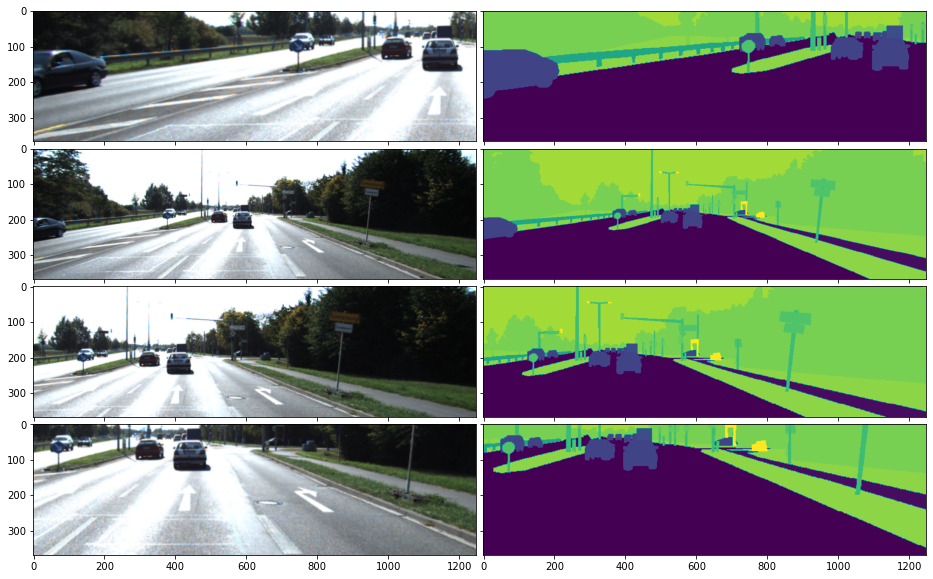

In [17]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(4, 2),
    axes_pad=0.1,
)

for i in range(0, 4 * 2, 2):
    image_augmented, label_augmented = random_zoom(image, label)

    grid[i].imshow(image_augmented)
    grid[i + 1].imshow(label_augmented)

# Augmentation Policy

The implementation of several data augmentation methods is now complete. The next step is to **integrate these augmentation functions into the training pipeline**.

Augmentations can be applied in various ways: sequentially, randomly, or according to a predefined **augmentation policy**, as explored in relevant [research literature](https://research.google/pubs/pub47890/).

An **augmentation policy** is composed of multiple **subpolicies**, where each subpolicy consists of several operations applied in sequence. Each operation can be associated with a specific probability of being applied. Below is an example of such an augmentation policy:


In [18]:
AUGMENTATION_POLICY = {
    "subpolicy0": [(random_contrast, 0.75), (random_zoom, 0.75)],
    "subpolicy1": [(random_gamma, 0.75), (random_zoom, 0.75)],
    "subpolicy2": [(random_noise, 0.75), (random_zoom, 0.75)],
    "subpolicy3": [(random_brightness, 0.75), (random_zoom, 0.75)],
    "subpolicy4": [(random_gamma, 0.75), (random_zoom, 0.00)],
    "subpolicy5": [(random_brightness, 0.75), (random_zoom, 0.00)],
}

For example, if `subpolicy0` is chosen, then we will apply at first `random_contrast` with probability `0.75`. Then we would apply `random_zoom` with probability `0.75` on the same image. Both operations are performed in squence. Such a randomized approach ensures a high diversity in the training examples which in turn leads to a better model performance.

## Apply Augmentation Policy

In this task, a function must be implemented to **apply a single subpolicy** to a training sample.

Steps to implement `apply_augmentation_subpolicy`:

1. **Retrieve the subpolicy components**: Extract the augmentation function and its associated probability.
2. **Generate a random decision**: Create a random float between 0 and 1.
3. **Apply augmentation conditionally**: If the random value is less than or equal to the probability, apply the augmentation function to the `(image, label)` pair. Otherwise, leave the image and label unchanged.

This ensures that each operation in a subpolicy is applied **probabilistically**, introducing controlled randomness into the training pipeline.


In [19]:
def apply_augmentation_subpolicy(image, label, subpolicy):
    """
    Applies a subpolicy to an input image and label. Return the augmented image and label.

    Arguments:
    - image -- tf.Tensor with shape [height, width, 3] representing the camera image
    - label -- tf.Tensor with shape [height, width] representing the label
    - subpolicy -- List that contains several tuples of (augmentation_fuc, probability)
                  where probability is in [0, 1]. Each tuple is called operation. The probability
                  determines the probability to apply the operation.

    Returns:
    - image -- Augmented tf.Tensor with shape [height, width, 3] representing the camera image
    - label -- Augmented tf.Tensor with shape [height, width] representing the label
    """

    for operation in subpolicy:
        # get the augmentation function from operation, remember that the function is the first element of an operation
        func = operation[0]  # func = None

        # get the probability from operation, remember that the probability is the second element of an operation
        prob = operation[1]  # prob = None

        # pull a random float from a uniform distribution from [0, 1]
        random_float = tf.random.uniform([], 0, 1)  # random_float = None

        # apply func to (image, label) only when random_float <= prob
        image, label = tf.cond(
            pred=random_float <= prob,  # pred = None,
            true_fn=lambda: func(image, label),  # true_fn=lambda: None,
            false_fn=lambda: (image, label),  # false_fn=lambda: None
        )

    return image, label

### `apply_augmentation_subpolicy`

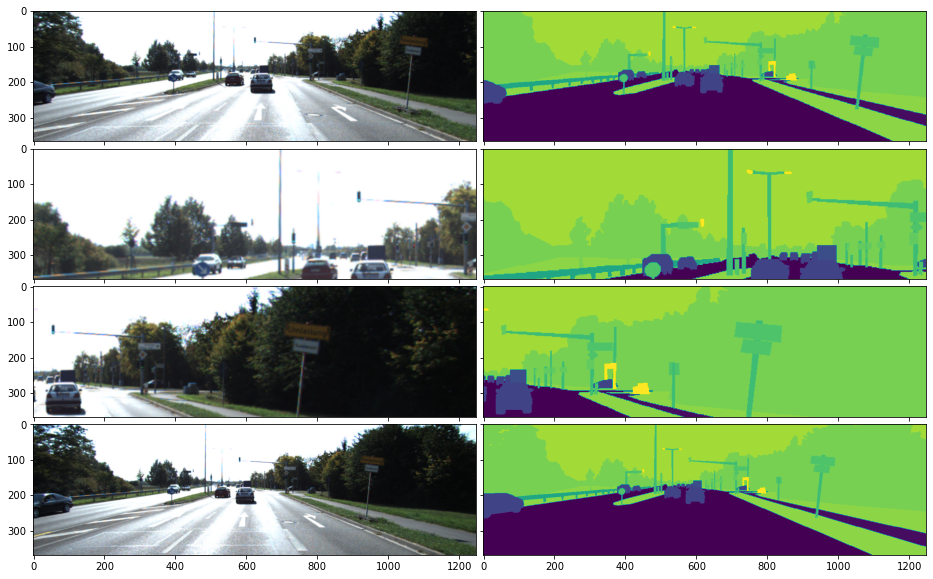

In [20]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(4, 2),
    axes_pad=0.1,
)

for i in range(0, 4 * 2, 2):
    image_augmented, label_augmented = apply_augmentation_subpolicy(
        image, label, AUGMENTATION_POLICY["subpolicy1"]
    )

    grid[i].imshow(image_augmented)
    grid[i + 1].imshow(label_augmented)

## Apply Augmentation Policy

In the previous task, a single subpolicy was applied to the input image-label pair. Now, the full **augmentation policy** will be applied. Each time the function is called, a **random subpolicy** is selected and applied to the image.

Steps to implement `apply_augmentation_policy`:

1. **Apply initial random flip**: Perform a `random_flip` on the input before any other augmentations.
2. **Select a random subpolicy**:

   * Determine the total number of subpolicies.
   * Generate a random integer between 0 and the total number of subpolicies. This integer identifies which subpolicy to apply.
3. **Iterate over subpolicies**:

   * Compare the index of each subpolicy with the randomly selected one.
   * If the index matches the random selection, apply `apply_augmentation_subpolicy` to the `(image, label)` pair using the corresponding subpolicy.
   * If it does not match, leave the `(image, label)` pair unchanged.

This approach ensures that **one randomly chosen subpolicy is applied per image**, introducing varied augmentations during training.


In [21]:
def apply_augmentation_policy(image, label, policy):
    """
    Applies a policy to a input image and label. Returns the augmented image and label.

    Arguments:
    - image -- tf.Tensor with shape [height, width, 3] representing the camera image
    - label -- tf.Tensor with shape [height, width] representing the label
    - policy -- Dictionary which contains subpolicies. Each element in the dictionary has
                the key `subpolicyX` where X represents the index starting from 0.

    Returns:
    - image -- Augmented tf.Tensor with shape [height, width, 3] representing the camera image
    - label -- Augmented tf.Tensor with shape [height, width] representing the label
    """

    # always radnom flip the image before any other augmentation
    image, label = random_flip(image, label)  # image, label = None

    # get the number of subpolicies
    num_policies = len(policy)  # num_policies = None

    # create a random integer in [0, num_policies)
    random_policy = tf.random.uniform(
        shape=[], minval=0, maxval=num_policies, dtype=tf.int32
    )  # random_policy = None

    # take all policies and choose random policy based on idx
    for idx in range(num_policies):
        image, label = tf.cond(
            pred=tf.equal(random_policy, idx),  # pred=None,
            true_fn=lambda: apply_augmentation_subpolicy(
                image, label, policy["subpolicy" + str(idx)]
            ),  #  true_fn=lambda: apply_augmentation_subpolicy(None, None, None),
            false_fn=lambda: (image, label),  # false_fn=lambda: None
        )

    return image, label

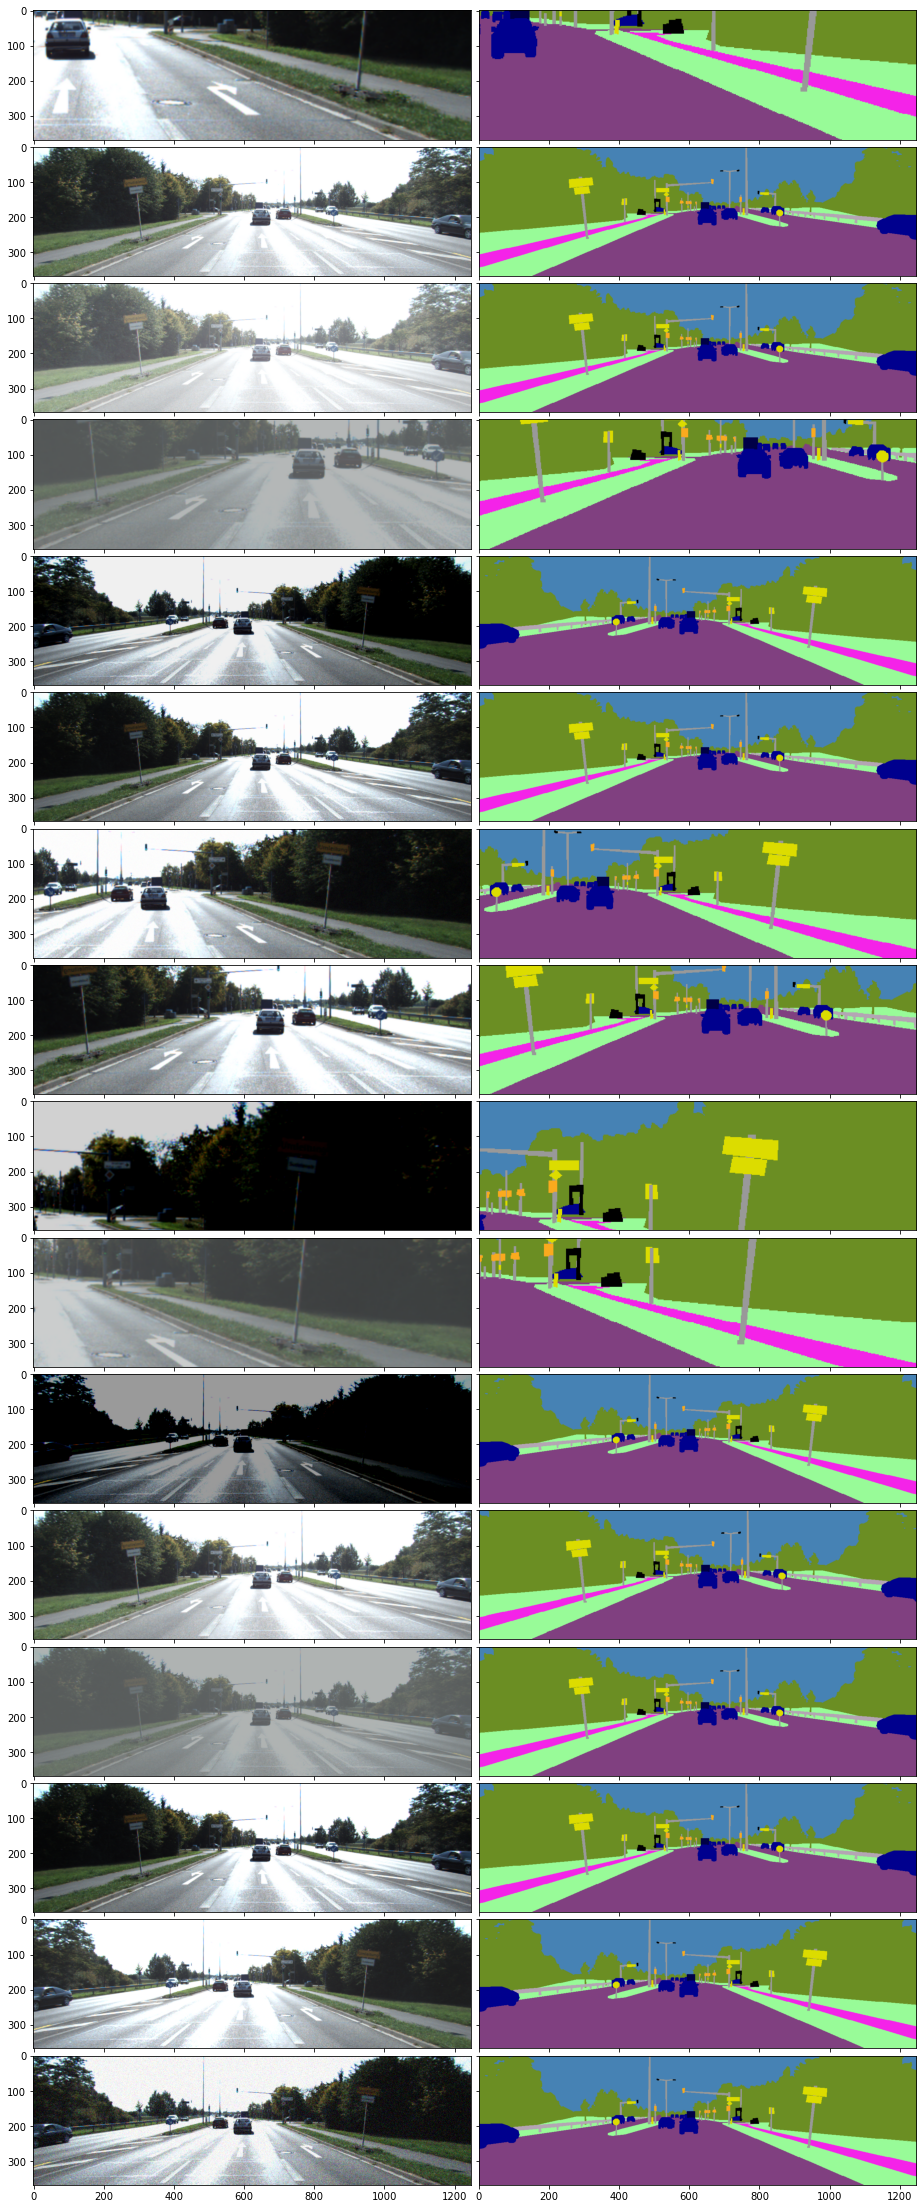

In [22]:
fig = plt.figure(figsize=(40, 40))

grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(16, 2),
    axes_pad=0.1,
)

for i in range(0, 16 * 2, 2):
    image_augmented, label_augmented = apply_augmentation_policy(
        image, label, AUGMENTATION_POLICY
    )
    label_augmented = segmentation_map_to_rgb_encoding(
        tf.squeeze(label_augmented), rgb_to_class_id
    )

    grid[i].imshow(image_augmented)
    grid[i + 1].imshow(label_augmented)

## Augmentation wrapper function

We have created our own augmentation function for semantic image segmentation. We can adjust the values or structure in `AUGMENTATION_POLICY` to obtain different augmentation results. We may also add more subpolicies or include more operations in each subpolicy. Next, we will create a wrapper function around `apply_augmentation_policy` to make it usable with the [tf.data API](https://www.tensorflow.org/guide/data).

In [23]:
def augmentation_wrapper(image, label):
    image, label = apply_augmentation_policy(image, label, AUGMENTATION_POLICY)
    return image, label

### normalization function


In [24]:
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

## Creating a Dataset with Augmentation

In the previous assignment, we explored how to use the [tf.data API](https://www.tensorflow.org/guide/data) to construct efficient data pipelines for training. Now, we aim to incorporate our augmentation function and policy into the input pipeline.

* Apply the augmentation to the dataset pipeline using the `map` method together with the `augmentation_wrapper` function. Be sure to set `num_parallel_calls` to `tf.data.AUTOTUNE`.
* Ensure that augmentation is performed only when the parameter `do_augmentation` is set to `True`.


In [25]:
def create_dataset(
    images_path, labels_path, batch_size=4, buffer_size=200, do_augmentation=False
):
    """
    Dataset creation function. Creates a input pipeline for semantic image segmentation.

    Arguments:
    - images_path -- List of Strings which contain pathes for the camera images
    - labels_path -- List of Strings which contain pathes for the label images
    - batch_size -- Integer - Size of the batches during data creation
    - buffer_size -- Integer - Size of the buffer for shuffeling
    - do_augmentation -- Boolean - If True, apply data augmentation

    Returns:
    - dataset -- tf.data.Dataset
    """

    dataset = tf.data.Dataset.from_tensor_slices((images_path, labels_path))
    # Shuffle the dataset with buffer_size
    dataset = dataset.shuffle(buffer_size=buffer_size)
    # Apply the parse_sample function. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = dataset.map(parse_sample, num_parallel_calls=tf.data.AUTOTUNE)

    # Apply augmentation policy
    if do_augmentation:  # if None:
        dataset = dataset.map(
            augmentation_wrapper, num_parallel_calls=tf.data.AUTOTUNE
        )  # dataset = None

    dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    # Apply batching to the dataset using batch_size
    dataset = dataset.batch(batch_size=batch_size)
    # Use prefetching
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

## Dataset creation

Similar to the previous example, we will use a train size of `70 %` and a validation size of `30 %`


In [26]:
train_size = round(len(images_path_train) * 0.7)

###  Build `train` and `val` Datasets

* Utilize the `create_dataset` function.
* Split the data by index, assigning `70%` for training and `30%` for validation.
* Set `do_augmentation=True` for the training dataset.
* Set `do_augmentation=False` for the validation dataset.


In [27]:
# Create the train dataset
train = create_dataset(
    images_path_train[:train_size], labels_path_train[:train_size], do_augmentation=True
)  # train = None

# Create the validation dataset
val = create_dataset(
    images_path_train[train_size:],
    labels_path_train[train_size:],
    do_augmentation=False,
)  # val = None

In [28]:
print("Train Dataset Length:", tf.data.experimental.cardinality(train).numpy())
print("Val Dataset Length:", tf.data.experimental.cardinality(val).numpy())

Train Dataset Length: 35
Val Dataset Length: 15


# Model training

We will load the U-Net segmentation model and compile it using the same parameters. Since the model architecture has already been built earlier, we can now directly call `getModel` to retrieve the segmentation model.

In [29]:
model = getModel(input_shape=[368, 1248, 3], num_classes=30)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=[SparseMeanIoU(num_classes=30, name="MIoU")],
)

We can now start training the model by using the `fit` method. For demonstration purposes, we will train for just one epoch, as running the full training would take several hours. In the following steps, we will instead make use of a pretrained model that has already been trained for several hundred steps with the augmented data pipeline.


In [30]:
history = model.fit(train, validation_data=val, epochs=1, verbose=1)

35/35 [==============================] - 95s 3s/step - loss: 2.6427 - MIoU: 0.0442 - val_loss: 3.1250 - val_MIoU: 0.0208


# Model Comparison

Next, we want to compare the accuracy of the segmentation models. One model was trained as in the previous assignment, without any augmentation, while the other was trained using our augmentation pipeline. Both models were trained for roughly 1000 epochs under identical settings.

We will begin by evaluating the model trained **without augmentation** by loading its weights into the graph.

In [ ]:
model.load_weights("segmentation_utils/pretrained_model/model")
result = model.evaluate(val)
print(result)

We can conclude that the model trained with augmented samples performs better than the one trained without augmentation. This shows that we were able to boost the model’s performance without introducing any additional training data.

# Model inference
We can now perform __inference__ on that model by loading a sample from the dataset and use the model's `predict` function.

In [ ]:
image, label = parse_sample(images_path_train[-1], labels_path_train[-1])
image = tf.expand_dims(image, axis=0)
probabilities = model.predict(tf.cast(image, tf.float32) / 255.0)

prediction = tf.argmax(probabilities, axis=-1)
prediction = tf.squeeze(prediction)

### Plot of the segmentation map
Now we can simply use matplotlib's `imshow` function to visualize the predictions and the label.

In [ ]:
plt.figure()
plt.imshow(prediction)
plt.title("Segmentation Map Prediction")
plt.show()

plt.figure()
plt.imshow(label)
plt.title("Segmentation Map Label")
plt.show()

In [ ]:
rgb_encoding = segmentation_map_to_rgb_encoding(prediction, rgb_to_class_id)

plt.figure(figsize=(12, 12))
plt.imshow(rgb_encoding)
plt.title("RGB Encoding Prediction")
plt.show()

rgb_encoding = segmentation_map_to_rgb_encoding(np.squeeze(label), rgb_to_class_id)

plt.figure(figsize=(12, 12))
plt.imshow(rgb_encoding)
plt.title("RGB Encoding Label")
plt.show()